![](https://mms.businesswire.com/media/20220223005313/en/1368024/23/Indeed_Logo_2022.jpg)

> This project offers deep insights into job market trends, salary drivers, and how the tone of job descriptions can influence compensation. Hybrid roles tend to come with higher salaries, while technical and leadership positions often have the best pay. These findings can help job seekers and employers better navigate the market, aligning job postings and expectations with current salary trends.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indeede-job-data/List_of_Jobs_to_Apply.csv


In [2]:
jobs = pd.read_csv('/kaggle/input/indeede-job-data/List_of_Jobs_to_Apply.csv')
jobs.head()

,Job Title,Company,Location,Salary($),Job-Type,Job-Description,Raw_Link
0,AI Content Writer,DataAnnotation,Remote,$20 - $25 an hour,Contract,You will have conversations with chatbots in o...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,AI Focused Biochemistry Postdoctoral Fellow,Lawrence Berkeley National Laboratory,"San Francisco Bay Area, CA","$77,172 - $103,704 a year",Not Provided,Berkeley Lab’s Applied Mathematics and Computa...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,MRI Technologist,Lenox Hill Radiology,"Freeport, NY 11520",$40 - $60 an hour,Part-time,Perform high quality MRI exams on incoming pat...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3,AI Content Writer (Tier 1),Outlier Ai,California,Not Provided,Not Provided,Flexible work schedule: Work whenever and wher...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
4,Google Cloud Platform Data Engineer,Publicis Sapient,"Houston, TX","$115,000 - $150,000 a year",Full-time,This position requires in-depth knowledge and ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


In [3]:
print(jobs.info())
# check for missing values
print(jobs.isnull().sum())

# drop na description jobs
jobs = jobs.dropna() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Title        15002 non-null  object
 1   Company          15002 non-null  object
 2   Location         15002 non-null  object
 3   Salary($)        15002 non-null  object
 4   Job-Type         15002 non-null  object
 5   Job-Description  14938 non-null  object
 6   Raw_Link         15002 non-null  object
dtypes: object(7)
memory usage: 820.5+ KB
None
Job Title           0
Company             0
Location            0
Salary($)           0
Job-Type            0
Job-Description    64
Raw_Link            0
dtype: int64


## Data Preprocessing

### Handle Salary Format

In [4]:
jobs['Salary($)']

0                 $20 - $25 an hour
1         $77,172 - $103,704 a year
2                 $40 - $60 an hour
3                      Not Provided
4        $115,000 - $150,000 a year
                    ...            
14997                  Not Provided
14998    $103,800 - $219,200 a year
14999                  Not Provided
15000    $129,200 - $268,900 a year
15001    $103,800 - $219,200 a year
Name: Salary($), Length: 14938, dtype: object

In [5]:
# replace "Not Provided" with NaN
jobs['Salary($)'] = jobs['Salary($)'].replace('Not Provided', np.nan)
# drop rows with nan values in the salary column
jobs = jobs.dropna(subset=['Salary($)'])

In [6]:
# extract numeric salary info
def extract_salary(salary_str):
    salary_range = re.findall(r'\$[\d,]+', salary_str)
    salary_range = [int(s.replace('$', '').replace(',', '')) for s in salary_range]
    
    if 'hour' in salary_str.lower():
        # convert hourly to yearly e.g., 40 hours/week and 52 weeks/year
        salary_range = [s * 40 * 52 for s in salary_range]
    
    if len(salary_range) == 1:
        return salary_range[0], salary_range[0]
    elif len(salary_range) == 2:
        return salary_range[0], salary_range[1]
    else:
        return np.nan, np.nan

In [7]:
jobs[['Min_Salary', 'Max_Salary']] = jobs['Salary($)'].apply(lambda x: pd.Series(extract_salary(x)))
jobs['Avg_Salary'] = jobs[['Min_Salary', 'Max_Salary']].mean(axis=1)
print(jobs[['Min_Salary', 'Max_Salary', 'Avg_Salary']].describe())

          Min_Salary     Max_Salary     Avg_Salary
count    5915.000000    5915.000000    5915.000000
mean   112155.352663  185954.891631  149055.122147
std     71991.818216   94581.856903   79729.054788
min        45.000000      45.000000      45.000000
25%     82600.000000  111770.000000   96860.000000
50%    103800.000000  208800.000000  161500.000000
75%    134000.000000  223100.000000  175545.000000
max    999999.000000  999999.000000  999999.000000


In [8]:
jobs['Avg_Salary'][:10]

0      46800.0
1      90438.0
2     104000.0
4     132500.0
5      31200.0
7      83200.0
10     78000.0
11     31200.0
12     78000.0
13     62500.0
Name: Avg_Salary, dtype: float64

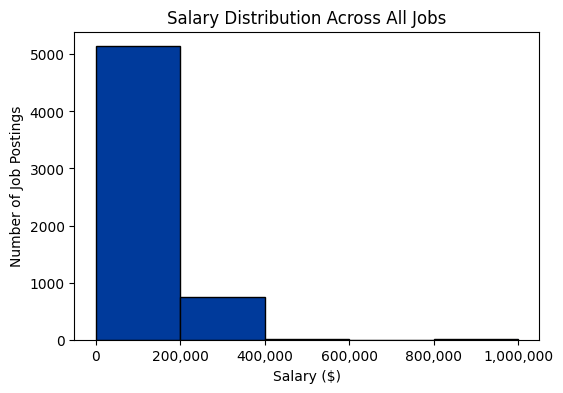

In [9]:
import matplotlib.ticker as mtick

plt.figure(figsize=(6, 4))
plt.hist(jobs['Avg_Salary'], bins=5, color='#003a9b', edgecolor='black')
plt.xlabel('Salary ($)')
plt.ylabel('Number of Job Postings')
plt.title('Salary Distribution Across All Jobs')
# format x-axis to show full numbers
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

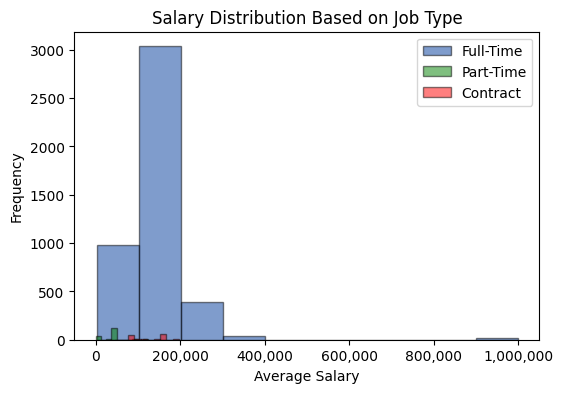

In [10]:
# filter data based on job type
full_time_salaries = jobs[jobs['Job-Type'] == 'Full-time']['Avg_Salary'].dropna()
part_time_salaries = jobs[jobs['Job-Type'] == 'Part-time']['Avg_Salary'].dropna()
contract_salaries = jobs[jobs['Job-Type'] == 'Contract']['Avg_Salary'].dropna()

plt.figure(figsize=(6, 4))
# Full-time salary histogram
plt.hist(full_time_salaries, bins=10, alpha=0.5, label='Full-Time', color='#003a9b', edgecolor='black')
# Part-time salary histogram
plt.hist(part_time_salaries, bins=10, alpha=0.5, label='Part-Time', color='green', edgecolor='black')
# Contract salary histogram
plt.hist(contract_salaries, bins=10, alpha=0.5, label='Contract', color='red', edgecolor='black')

plt.xlabel('Average Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution Based on Job Type')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend()
plt.show()

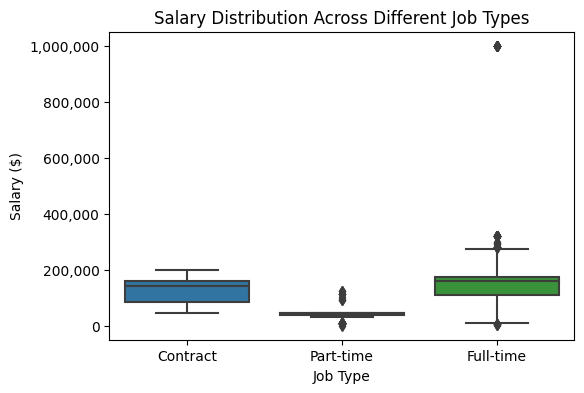

In [11]:
# Filter the DataFrame to include only Full-time, Part-time, and Contract jobs
filtered_df = jobs[jobs['Job-Type'].isin(['Full-time', 'Part-time', 'Contract'])]

# Create the box plot for the filtered data
plt.figure(figsize=(6, 4))
sns.boxplot(x='Job-Type', y='Avg_Salary', data=filtered_df)
plt.xlabel('Job Type')
plt.ylabel('Salary ($)')
plt.title('Salary Distribution Across Different Job Types')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{int(y):,}'))
plt.show()

## Data Exploration

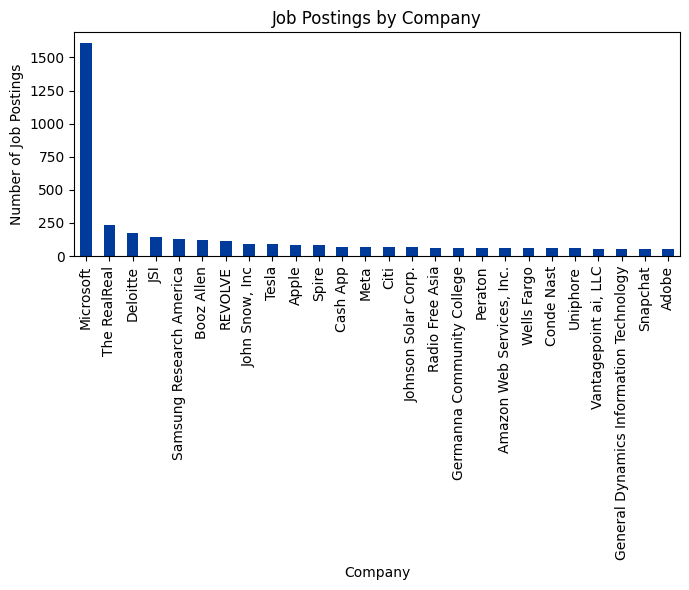

In [12]:
company_counts = jobs['Company'].value_counts()
# filter out companies with fewer than 50 postings
filtered_counts = company_counts[company_counts >= 50]
# visualization
plt.figure(figsize=(7, 6))
filtered_counts.plot(kind='bar', color='#003a9b')
plt.title('Job Postings by Company')
plt.xlabel('Company')
plt.ylabel('Number of Job Postings')
plt.tight_layout()

# Show the plot
plt.show()

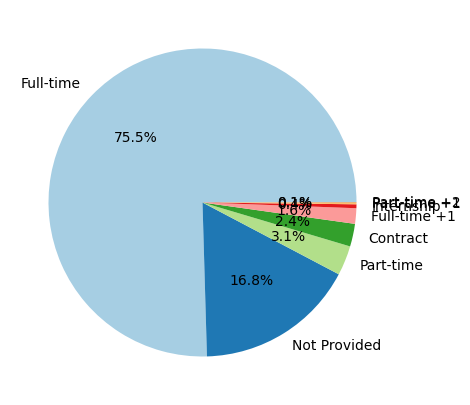

In [13]:
job_type_counts = jobs['Job-Type'].value_counts()

# define a threshold for small job types
threshold = 3

# Filter out job types with fewer than the threshold
filtered_job_type_counts = job_type_counts[job_type_counts >= threshold]

# Include 'Other' for small job types
other_counts = job_type_counts[job_type_counts < threshold]

# Plot the data
plt.figure(figsize=(6,5))
filtered_job_type_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired(range(len(filtered_job_type_counts))))
plt.ylabel('')
plt.show()

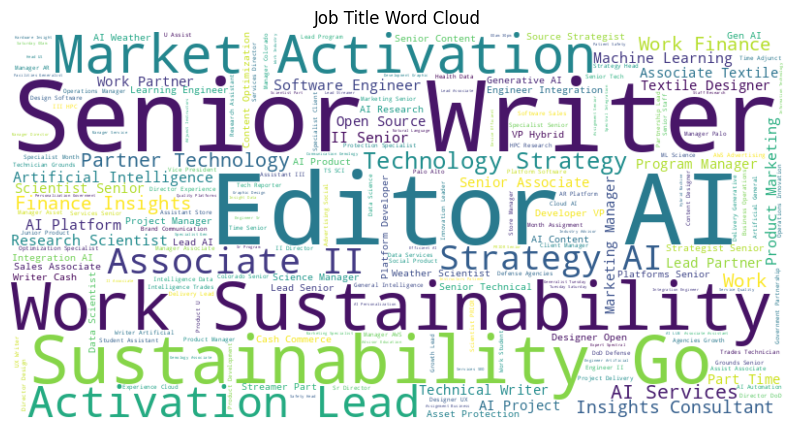

In [14]:
from wordcloud import WordCloud
# combine all job descriptions into one large text
text = ' '.join(jobs['Job Title'].dropna())

# generate and plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Job Title Word Cloud')
plt.show()

Job Description Length

In [15]:
jobs['Job_Description_Length'] = jobs['Job-Description'].apply(lambda x: len(str(x).split()))
print(jobs[['Job-Description', 'Job_Description_Length']])

                                         Job-Description  \
0      You will have conversations with chatbots in o...   
1      Berkeley Lab’s Applied Mathematics and Computa...   
2      Perform high quality MRI exams on incoming pat...   
4      This position requires in-depth knowledge and ...   
5      Flexible work schedule: Work whenever and wher...   
...                                                  ...   
14990  Then bring your extensive coding experience an...   
14991  Provide strategic leadership and vision for th...   
14998  The writer and editor will also contribute reg...   
15000  Sitting in the Cross Solutions Sales Activatio...   
15001  As a Partner Technology Strategist, you will d...   

       Job_Description_Length  
0                          26  
1                          21  
2                          19  
4                          22  
5                          17  
...                       ...  
14990                      22  
14991                  

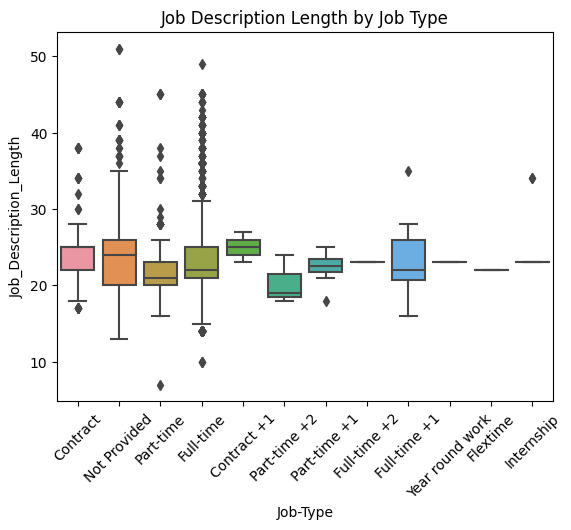

In [16]:
# Correlation with Job Type
sns.boxplot(x='Job-Type', y='Job_Description_Length', data=jobs)
plt.title('Job Description Length by Job Type')
plt.xticks(rotation=45)
plt.show()

### NLP

#### Key phrases

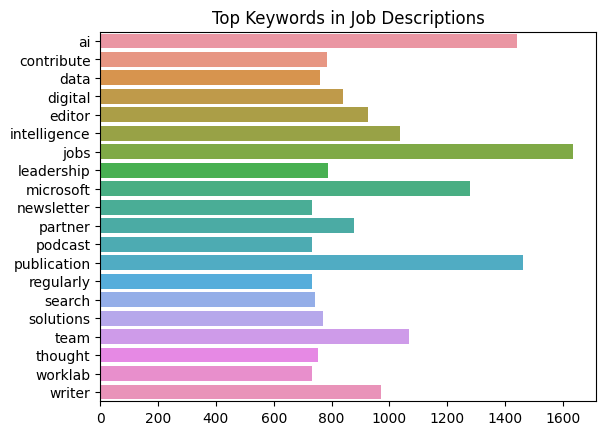

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract top keywords from job descriptions
vectorizer = CountVectorizer(max_features=20, stop_words='english')
X = vectorizer.fit_transform(jobs['Job-Description'].astype(str))
keywords = vectorizer.get_feature_names_out()

# Visualize the most common keywords
sns.barplot(x=X.toarray().sum(axis=0), y=keywords)
plt.title('Top Keywords in Job Descriptions')
plt.show()

### Sentiment Analysis

In [18]:
# calculate sentiment polarity and subjectivity
jobs['Sentiment_Polarity'] = jobs['Job-Description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
jobs['Sentiment_Subjectivity'] = jobs['Job-Description'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
print(jobs[['Job-Description', 'Sentiment_Polarity', 'Sentiment_Subjectivity']])

                                         Job-Description  Sentiment_Polarity  \
0      You will have conversations with chatbots in o...            0.000000   
1      Berkeley Lab’s Applied Mathematics and Computa...            0.000000   
2      Perform high quality MRI exams on incoming pat...            0.160000   
4      This position requires in-depth knowledge and ...            1.000000   
5      Flexible work schedule: Work whenever and wher...            0.000000   
...                                                  ...                 ...   
14990  Then bring your extensive coding experience an...            0.000000   
14991  Provide strategic leadership and vision for th...            0.666667   
14998  The writer and editor will also contribute reg...            0.000000   
15000  Sitting in the Cross Solutions Sales Activatio...            0.000000   
15001  As a Partner Technology Strategist, you will d...            0.045455   

       Sentiment_Subjectivity  
0      

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


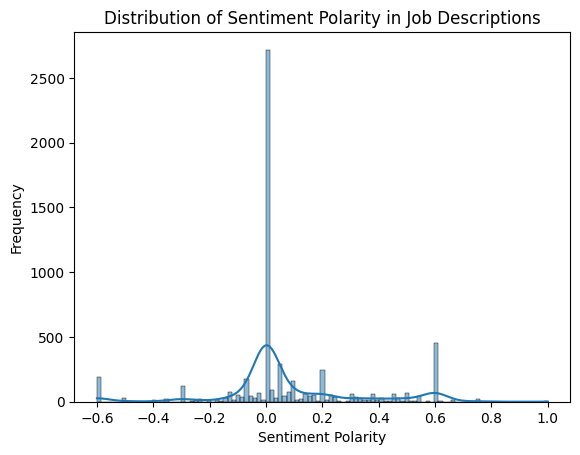

In [19]:
# plot the distribution of sentiment polarity
sns.histplot(jobs['Sentiment_Polarity'], kde=True)
plt.title('Distribution of Sentiment Polarity in Job Descriptions')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


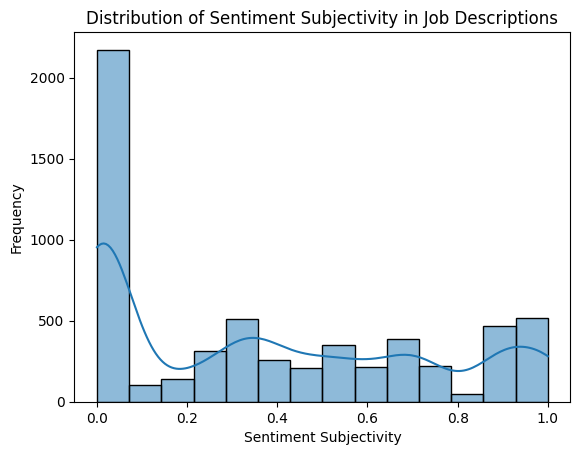

In [20]:
sns.histplot(jobs['Sentiment_Subjectivity'], kde=True)
plt.title('Distribution of Sentiment Subjectivity in Job Descriptions')
plt.xlabel('Sentiment Subjectivity')
plt.ylabel('Frequency')
plt.show()

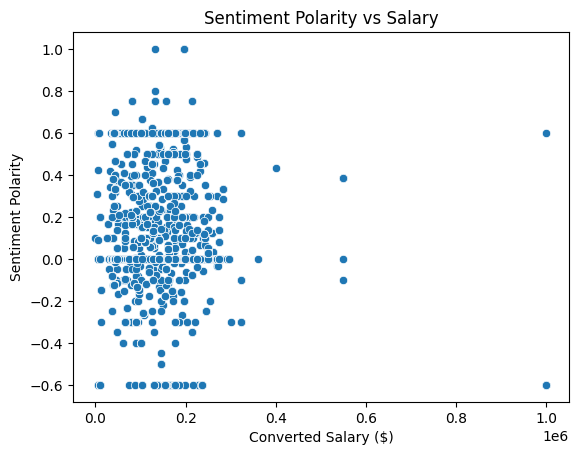

In [21]:
sns.scatterplot(x='Avg_Salary', y='Sentiment_Polarity', data=jobs)
plt.title('Sentiment Polarity vs Salary')
plt.xlabel('Converted Salary ($)')
plt.ylabel('Sentiment Polarity')
plt.show()

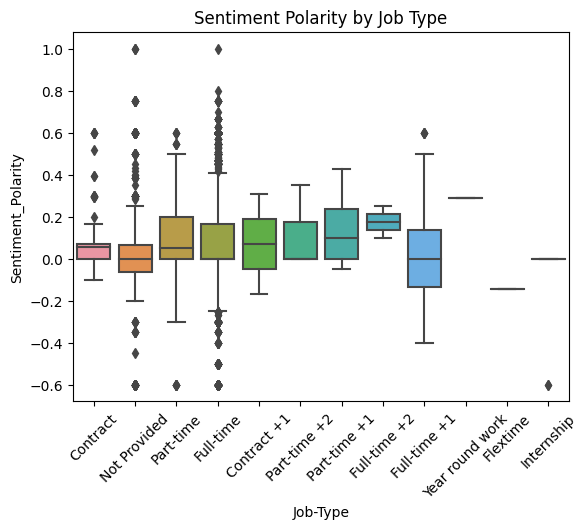

In [22]:
sns.boxplot(x='Job-Type', y='Sentiment_Polarity', data=jobs)
plt.title('Sentiment Polarity by Job Type')
plt.xticks(rotation=45)
plt.show()

## Predictive Modeling

## 1. Salary prediction
- build a machine learning model to predict avg salary based on job titles, locations, and companies

In [23]:
jobs.head()

,Job Title,Company,Location,Salary($),Job-Type,Job-Description,Raw_Link,Min_Salary,Max_Salary,Avg_Salary,Job_Description_Length,Sentiment_Polarity,Sentiment_Subjectivity
0,AI Content Writer,DataAnnotation,Remote,$20 - $25 an hour,Contract,You will have conversations with chatbots in o...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,41600,52000,46800.0,26,0.00,0.00
1,AI Focused Biochemistry Postdoctoral Fellow,Lawrence Berkeley National Laboratory,"San Francisco Bay Area, CA","$77,172 - $103,704 a year",Not Provided,Berkeley Lab’s Applied Mathematics and Computa...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,77172,103704,90438.0,21,0.00,0.00
2,MRI Technologist,Lenox Hill Radiology,"Freeport, NY 11520",$40 - $60 an hour,Part-time,Perform high quality MRI exams on incoming pat...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,83200,124800,104000.0,19,0.16,0.54
4,Google Cloud Platform Data Engineer,Publicis Sapient,"Houston, TX","$115,000 - $150,000 a year",Full-time,This position requires in-depth knowledge and ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,115000,150000,132500.0,22,1.00,0.30
5,AI Content Editor (Tier 1),Outlier Ai,"Gulfport, MS",Up to $15 an hour,Not Provided,Flexible work schedule: Work whenever and wher...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,31200,31200,31200.0,17,0.00,0.00


#### 1) Group job titles based on keywords
- convert all titles to lowercase and remove special characters/numbers
- create a mapping for common themes

In [24]:
salaries = jobs.copy()

In [25]:
# apply .lower() to each cell; remove unnecessary spaces at the beginning/end of the titles
salaries['Job Title'] = salaries['Job Title'].str.lower().str.strip()
# remove special characters (not word characters (\w) or whitespace (\s))
salaries['Job Title'] = salaries['Job Title'].str.replace('[^\w\s]', '', regex=True)
print(salaries['Job Title'].head(20))

0                                     ai content writer
1           ai focused biochemistry postdoctoral fellow
2                                      mri technologist
4                   google cloud platform data engineer
5                              ai content editor tier 1
7               software developer  ai trainer contract
10    ai trainer for japanese writers freelance remo...
11                          ai writing evaluator tier 1
12                            contract technical writer
13       highlevel crm automation  reporting specialist
17       highlevel crm automation  reporting specialist
19                   artificial intelligence specialist
23                document automation sales  consulting
27                           document specialist remote
29                                        private tutor
30                           document specialist remote
31                                        private tutor
32                                          seo 

In [26]:
# words_to_remove = ['remote', 'contract', 'tier 1', 'freelance', 'earn up to', 'adjunt', 'faculty', 'instructor',  
                   # 'ii', 'iii', 'vii', 'corporate', 'graduate', 'reporter', 'highlevel crm']

# standardize specific job titles
title_mapping = {
    'data analyst': 'data analyst',
    'data analysis': 'data analyst',
    'data scientist': 'data scientist',
    'data science': 'data scientist',
    'partner technology strategy ai services': 'ai engineer',
    'ai engineer': 'ai engineer',
    'artificial intelligence': 'ai engineer',
    'ml engineer': 'ai engineer',
    'senior ai weather scientist': 'ai engineer',
    'machine learning': 'ai engineer',
    'software engineer': 'software engineer',
    'software developer': 'software engineer',
    'research engineer': 'research engineer',
    'gen ai platform developer vp hybrid': 'gen ai developer',
    'seo and ai content optimization specialist': 'seo specialist',
    'writer and editor ai at work': 'ai writer and editor',
    'senior technical writer cash commerce': 'technical writer',
    'assistant store manager palo alto': 'assistant store manager',
    'sustainability gotomarket activation lead': 'activation lead',
    'product marketing manager ar platform': 'product manager'
}

#clean up extra spaces
salaries['Job Title'] = salaries['Job Title'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [27]:
def map_to_title(title):
    title = title.lower()
    # remove extra space in the title
    title = ' '.join(title.split())  # ensure single spaces between words
    for key in title_mapping.keys():
        if key in title:
            return title_mapping[key]
    return title

salaries['Job Title'] = salaries['Job Title'].apply(map_to_title)
#remove any rows with empty or single-space job titles
salaries = salaries[salaries['Job Title'].str.strip() != '']

# only keep value_counts() > 50 to be considered for current project
salaries = salaries.groupby('Job Title').filter(lambda x: len(x)>50)
print(len(salaries))
print(salaries['Job Title'].value_counts())

3498
Job Title
ai writer and editor                 939
ai engineer                          570
activation lead                      344
associate ii                         237
finance insights consultant          178
data scientist                       143
software engineer                    132
senior associate textile designer    113
open source strategist                92
technical writer                      78
ai project manager                    75
streamerpart time                     65
gen ai developer                      65
trades technician grounds             63
seo specialist                        63
senior tech reporter                  61
director of product uassist           60
asset protection specialist           60
software sales                        55
assistant store manager               54
product manager                       51
Name: count, dtype: int64


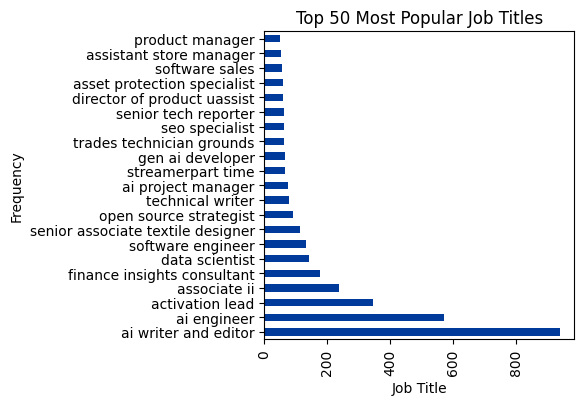

In [28]:
plt.figure(figsize=(4, 4))
salaries['Job Title'].value_counts().plot(kind='barh', color='#003a9b')
plt.xticks(rotation=90)
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.title('Top 50 Most Popular Job Titles')
plt.show()

In [29]:
# further categorize titles into general categories
general_title_mapping = {
    'manager': 'Management',
    'director': 'Management',
    'vice president': 'Management',
    'vp': 'Management',
    'scientist': 'Science & Research',
    'research': 'Science & Research',
    'data': 'Data Science',
    'ai': 'AI & Machine Learning',
    'machine learning': 'AI & Machine Learning',
    'ml': 'AI & Machine Learning',
    'software engineer':'Software Engineer',
    'sales': 'Sales',
    'marketing': 'Marketing',
    'technician': 'Technical Support',
    'writer': 'Writing & Content',
    'designer': 'Design',
    'architect': 'Engineering',
    'professor': 'Education',
    'postdoctoral': 'Education',
    'fellow': 'Education',
    'consultant': 'Consulting',
    'consulting': 'Consulting',
    'administrator': 'Administration',
    'lead': 'Leadership',
    'principal': 'Leadership',
    'associate': 'Administration',
    'strategist': 'Strategy & Consulting',
    'streamer': 'Content Creation',
    'seo': 'Marketing',
    'reporter': 'Journalism & Media',
    'protection': 'Security'
}
def map_to_general_category(title):
    title = title.lower()
    title = ' '.join(title.split())  # Ensure single spaces between words
    for key in general_title_mapping.keys():
        if key in title:
            return general_title_mapping[key]
    return 'Other'  # A default category for uncategorized titles

salaries['General Category'] = salaries['Job Title'].apply(map_to_general_category)
print(len(salaries))
print(salaries['General Category'].value_counts())

3498
General Category
AI & Machine Learning    1574
Leadership                344
Management                240
Administration            237
Consulting                178
Science & Research        143
Software Engineer         132
Design                    113
Strategy & Consulting      92
Writing & Content          78
Content Creation           65
Marketing                  63
Technical Support          63
Journalism & Media         61
Security                   60
Sales                      55
Name: count, dtype: int64


In [30]:
salaries.groupby(salaries['General Category']=='Other')['Job Title'].value_counts()

General Category  Job Title                        
False             ai writer and editor                 939
                  ai engineer                          570
                  activation lead                      344
                  associate ii                         237
                  finance insights consultant          178
                  data scientist                       143
                  software engineer                    132
                  senior associate textile designer    113
                  open source strategist                92
                  technical writer                      78
                  ai project manager                    75
                  gen ai developer                      65
                  streamerpart time                     65
                  seo specialist                        63
                  trades technician grounds             63
                  senior tech reporter                  61
    

#### 2) Clean & Group location based on keywords

In [31]:
def map_to_city(location):
    location = location.lower().strip()
    if 'remote' in location:
        return 'remote'
    
    match = re.match(r'([a-z\s]+),\s*[a-z]{2}', location)
    if match:
        return match.group(1).strip().title()
    parts = location.split(',')
    if len(parts)>0:
        return parts[0].strip().title() # for location with no specific city
    

def map_to_country(location):
    location = location.lower().strip()
    if location == 'remote':
        return 'remote'.title()
    if 'united states' in location or re.search(r'\b(us|usa|america)\b', location):
        return 'USA'
    if 'canada' in location:
        return 'Canada'
    if 'uk' in location or 'united kingdom' in location:
        return 'UK'
    if 'australia' in location:
        return 'Australia'
    
    # Check for state codes (assuming USA)
    state_codes = ['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 
                   'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 
                   'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 
                   'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy']       
    canada_province_codes = ['ab', 'bc', 'mb', 'nb', 'nl', 'ns', 'nt', 'nu', 'on', 'pe', 'qc', 'sk', 'yt']
    
    if any(state_code in location for state_code in state_codes):
        return 'USA'
    if any(province_code in location for province_code in canada_province_codes):
        return 'Canada'
    # fallback
    return 'Unknown'

In [32]:
salaries['City'] = salaries['Location'].apply(map_to_city)
salaries['Country'] = salaries['Location'].apply(map_to_country)
print(salaries[['Location', 'City', 'Country']].head(20))

                              Location            City Country
7                 Remote in Austin, TX          remote     USA
19                              Remote          remote  Remote
33     Miami, FL 33132 (Downtown area)           Miami     USA
42                          Eugene, OR          Eugene     USA
44   Redmond, WA 98052 (Overlake area)         Redmond     USA
45                  Salt Lake City, UT  Salt Lake City     USA
47                 San Diego, CA 92122       San Diego     USA
58                   San Francisco, CA   San Francisco     USA
60                          Eugene, OR          Eugene     USA
61                        San Jose, CA        San Jose     USA
73                                Utah            Utah     USA
76                   San Francisco, CA   San Francisco     USA
83              Remote in New York, NY          remote     USA
85                 Annapolis, MD 21401       Annapolis     USA
88                              Remote          remote 

In [33]:
salaries['Country'].value_counts()

Country
USA       3493
Remote       5
Name: count, dtype: int64

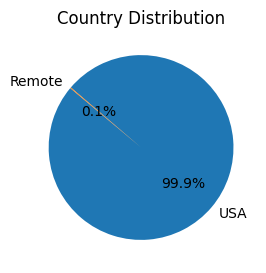

In [34]:
plt.figure(figsize=(3, 3))
country_distribution = salaries['Country'].value_counts()
plt.pie(country_distribution, labels=country_distribution.index, autopct='%1.1f%%', startangle=140) 
# displays the percentage on each wedge with one decimal place; starts the pie chart at an angle of 140 degrees 
plt.title('Country Distribution')
plt.show()

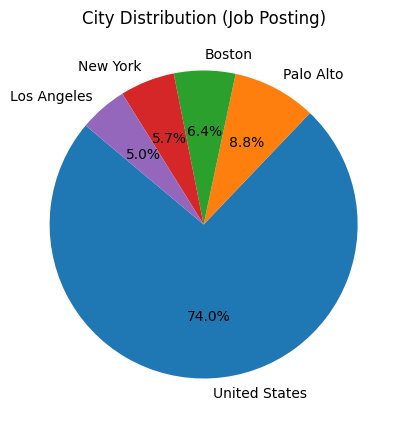

In [35]:
plt.figure(figsize=(5, 5))
city_distribution = salaries['City'].value_counts()
city_distribution = city_distribution[city_distribution>110]
plt.pie(city_distribution, labels=city_distribution.index, autopct='%1.1f%%', startangle=140) 
# displays the percentage on each wedge with one decimal place; starts the pie chart at an angle of 140 degrees 
plt.title('City Distribution (Job Posting)')
plt.show()

> Since this dataset is almost all about US, we'll focus on the city as our location indicator

#### 3) Companies

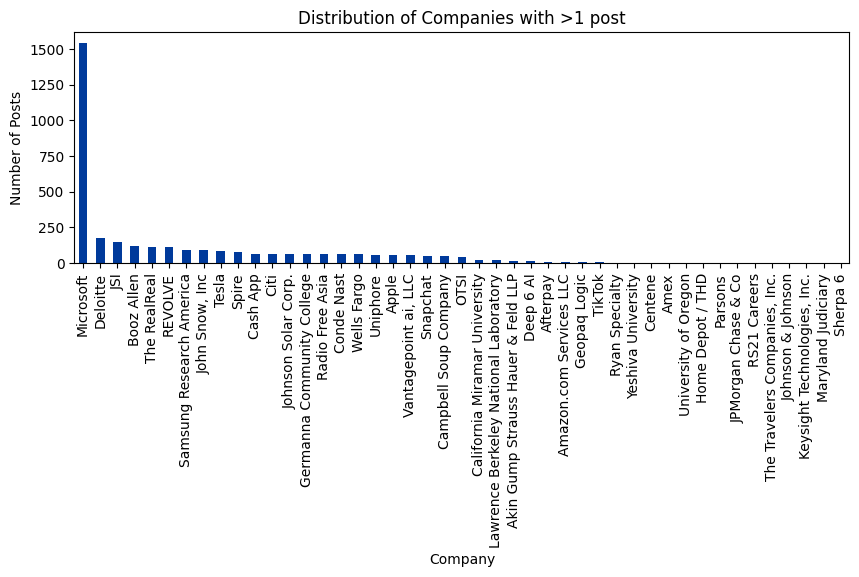

In [36]:
# let's focus on companies with more than 1 post
morethan1 = salaries['Company'].value_counts()
morethan1 = morethan1[morethan1>1]
plt.figure(figsize=(10, 3))
morethan1.plot(kind='bar', color='#003a9b')
plt.xlabel('Company')
plt.ylabel('Number of Posts')
plt.title('Distribution of Companies with >1 post')
plt.show()

In [37]:
salaries.head()

,Job Title,Company,Location,Salary($),Job-Type,Job-Description,Raw_Link,Min_Salary,Max_Salary,Avg_Salary,Job_Description_Length,Sentiment_Polarity,Sentiment_Subjectivity,General Category,City,Country
7,software engineer,DataAnnotation,"Remote in Austin, TX",$40 an hour,Contract,You will work with the chatbots that we are bu...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,83200,83200,83200.0,30,0.600000,1.000000,Software Engineer,remote,USA
19,ai engineer,SNAPtivities,Remote,$15 - $25 an hour,Part-time +2,"In this role, you will play a key role in deve...",https://www.indeed.com/rc/clk?jk=2ae39d625ed4e...,31200,52000,41600.0,24,0.000000,1.000000,AI & Machine Learning,remote,Remote
33,ai engineer,Miami Dade College,"Miami, FL 33132 (Downtown area)",$59.57 an hour,Part-time +1,The Adjunct Faculty member teaches Artificial ...,https://www.indeed.com/rc/clk?jk=1dd8819c55c78...,122720,122720,122720.0,21,0.200000,1.000000,AI & Machine Learning,Miami,USA
42,ai engineer,University of Oregon,"Eugene, OR","$136,400 - $181,000 a year",Full-time,"Categories:* Administrative/Professional, Exec...",https://www.indeed.com/rc/clk?jk=defe5fa6e1eb4...,136400,181000,158700.0,10,0.000000,0.000000,AI & Machine Learning,Eugene,USA
44,data scientist,Microsoft,"Redmond, WA 98052 (Overlake area)","$98,300 - $208,800 a year",Full-time,Business Applications & Platform products hera...,https://www.indeed.com/rc/clk?jk=687880f4200a5...,98300,208800,153550.0,21,0.136364,0.454545,Science & Research,Redmond,USA


In [38]:
# features = ['Job Title', 'City', 'Company', 'Job-Type']
features = ['General Category', 'City', 'Company', 'Job-Type']
X = salaries[features + ['Job_Description_Length']]
y = salaries['Avg_Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# onehotencoding categorical features and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # scale the one-hot encoded features
    ('model', '')
])

# hyperparameter tuning using GridSearchCV 
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 10]
    },
    'Support Vector Regressor': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'K-Nearest Neighbors': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    }
}

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

In [40]:
import joblib
import os

results = {}
best_overall_model = None
best_overall_score = float('inf')  # initialize to a very large value
best_model_name = ""

model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# evaluate each model
for name, model in models.items():
    pipeline.set_params(model=model)
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_
        print("Best Parameters:", best_params)
        print("Best MAE Score:", best_score)
    else:
        best_model = pipeline.fit(X_train, y_train)
    
    # evaluate the best model on the test set
    y_pred = best_model.predict(X_test)   
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-squared': r2
    }
    # Save the model for each algorithm
    model_filename = os.path.join(model_dir, f"best_model_{name}.pkl")
    joblib.dump(best_model, model_filename)
    print(f"Saved model for {name}: {model_filename}")
    
    # save the overall best model
    if mae < best_overall_score:
        best_overall_score = mae
        best_overall_model = best_model
        best_model_name = name

results_df = pd.DataFrame(results).T
print(results_df)
print(f"\nBest Overall Model: {best_model_name} with MAE: {best_overall_score}")

Saved model for Linear Regression: saved_models/best_model_Linear Regression.pkl
Best Parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best MAE Score: 1516.2138353738844
Saved model for Random Forest: saved_models/best_model_Random Forest.pkl
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200}
Best MAE Score: 909.6155415774972
Saved model for Gradient Boosting: saved_models/best_model_Gradient Boosting.pkl
Best Parameters: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best MAE Score: 9458.285406707564
Saved model for Support Vector Regressor: saved_models/best_model_Support Vector Regressor.pkl
Best Parameters: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Best MAE Score: 904.5455686156081
Saved model for K-Nearest Neighbors: saved_models/best_model_K-Nearest Neighbors.pkl
                                  MAE           MSE          RMSE  R-squared
Linear Regre

> * Random Forest: max_depth=20, min_samples_split=2, n_estimators=200
> * Gradient Boosting: learning_rate=0.1, max_depth=10, n_estimators=200
> * Support Vector Regressor: C=10, gamma='scale', kernel='linear'
> * K-Nearest Neighbors: n_neighbors=7, weights='distance'

Based on the metrics, K-Nearest Neighbors and Gradient Boosting seem to perform well, particularly K-Nearest Neighbors with the lowest MAE and RMSE. Linear Regression also shows strong performance with a high R-squared and competitive errors.

In [41]:
print(best_model)
best_model.fit(X_train, y_train)
best_model.predict(X_test)
y_pred = best_model.predict(X_test)   
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['General Category', 'City',
                                                   'Company', 'Job-Type'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('model',
                 KNeighborsRegressor(n_neighbors=7, weights='distance'))])
MAE: 957.9194372584587
MSE: 68104046.8077462
R2: 0.9747748490428266


#### Feature Importance

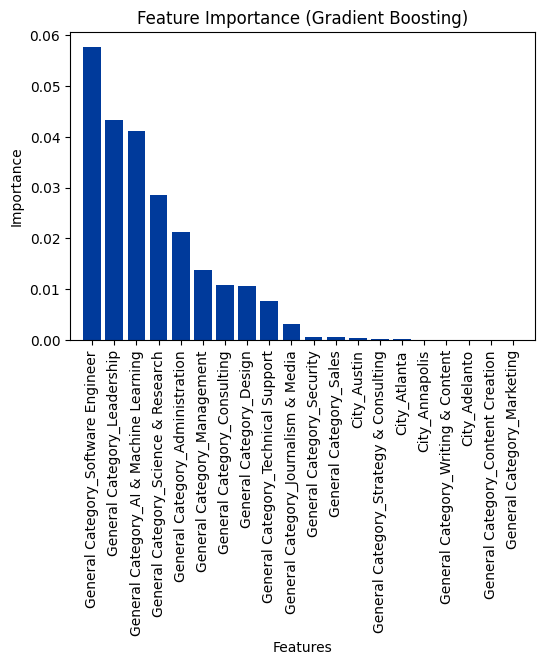

In [42]:
gradient_boosting_model = joblib.load('saved_models/best_model_Gradient Boosting.pkl')
importances = gradient_boosting_model.named_steps['model'].feature_importances_[:20]
feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features)
# sort importance
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(6, 4))
plt.title('Feature Importance (Gradient Boosting)')
plt.bar(range(len(importances)), importances[indices], align='center', color='#003a9b')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

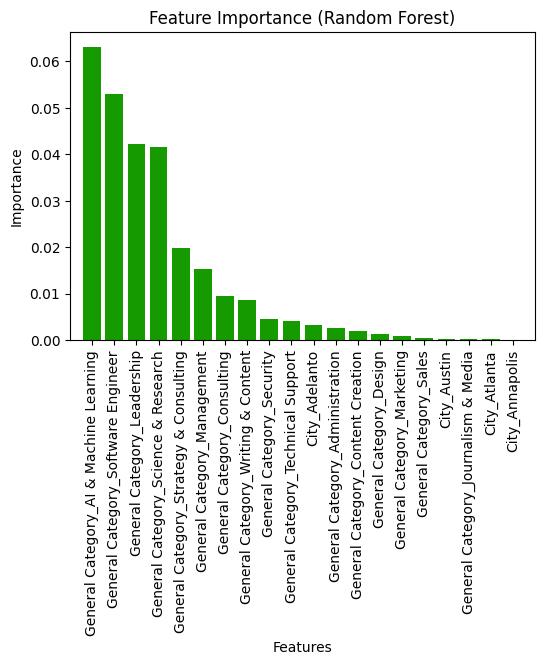

In [43]:
rf_model = joblib.load('saved_models/best_model_Random Forest.pkl')
rf_importances = rf_model.named_steps['model'].feature_importances_[:20]
rf_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features)
# sort importance
rf_indices = np.argsort(rf_importances)[::-1] #reverses the order of the indices, changing the sort from ascending to descending
plt.figure(figsize=(6, 4))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(len(rf_importances)), rf_importances[rf_indices], align='center', color='#159b00')
plt.xticks(range(len(rf_importances)), rf_feature_names[rf_indices], rotation=90)
plt.xlim([-1, len(rf_importances)])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## 2. Sentiment analysis of job descriptions
- can we analyze the sentiment of job descriptions and correlate it with the offered salary or job type?

In [44]:
salaries.head()

,Job Title,Company,Location,Salary($),Job-Type,Job-Description,Raw_Link,Min_Salary,Max_Salary,Avg_Salary,Job_Description_Length,Sentiment_Polarity,Sentiment_Subjectivity,General Category,City,Country
7,software engineer,DataAnnotation,"Remote in Austin, TX",$40 an hour,Contract,You will work with the chatbots that we are bu...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,83200,83200,83200.0,30,0.600000,1.000000,Software Engineer,remote,USA
19,ai engineer,SNAPtivities,Remote,$15 - $25 an hour,Part-time +2,"In this role, you will play a key role in deve...",https://www.indeed.com/rc/clk?jk=2ae39d625ed4e...,31200,52000,41600.0,24,0.000000,1.000000,AI & Machine Learning,remote,Remote
33,ai engineer,Miami Dade College,"Miami, FL 33132 (Downtown area)",$59.57 an hour,Part-time +1,The Adjunct Faculty member teaches Artificial ...,https://www.indeed.com/rc/clk?jk=1dd8819c55c78...,122720,122720,122720.0,21,0.200000,1.000000,AI & Machine Learning,Miami,USA
42,ai engineer,University of Oregon,"Eugene, OR","$136,400 - $181,000 a year",Full-time,"Categories:* Administrative/Professional, Exec...",https://www.indeed.com/rc/clk?jk=defe5fa6e1eb4...,136400,181000,158700.0,10,0.000000,0.000000,AI & Machine Learning,Eugene,USA
44,data scientist,Microsoft,"Redmond, WA 98052 (Overlake area)","$98,300 - $208,800 a year",Full-time,Business Applications & Platform products hera...,https://www.indeed.com/rc/clk?jk=687880f4200a5...,98300,208800,153550.0,21,0.136364,0.454545,Science & Research,Redmond,USA


In [45]:
polarity_salary_corr = salaries['Sentiment_Polarity'].corr(salaries['Avg_Salary'])
subjectivity_salary_corr = salaries['Sentiment_Subjectivity'].corr(salaries['Avg_Salary'])
print(f"Correlation between Sentiment Polarity and Avg Salary: {polarity_salary_corr}")
print(f"Correlation between Sentiment Subjectivity and Avg Salary: {subjectivity_salary_corr}")

Correlation between Sentiment Polarity and Avg Salary: 0.049542551065822414
Correlation between Sentiment Subjectivity and Avg Salary: -0.12831284574392463


In [46]:
avg_polarity_by_job_type = salaries.groupby('Job-Type')['Sentiment_Polarity'].mean()
avg_subjectivity_by_job_type = salaries.groupby('Job-Type')['Sentiment_Subjectivity'].mean()

print("Average Sentiment Polarity by Job Type:")
print(avg_polarity_by_job_type)

print("\nAverage Sentiment Subjectivity by Job Type:")
print(avg_subjectivity_by_job_type)

Average Sentiment Polarity by Job Type:
Job-Type
Contract        0.093030
Full-time       0.080996
Full-time +1   -0.175000
Not Provided    0.019608
Part-time       0.034156
Part-time +1    0.200000
Part-time +2    0.000000
Name: Sentiment_Polarity, dtype: float64

Average Sentiment Subjectivity by Job Type:
Job-Type
Contract        0.305657
Full-time       0.299101
Full-time +1    0.500000
Not Provided    0.424584
Part-time       0.193019
Part-time +1    1.000000
Part-time +2    1.000000
Name: Sentiment_Subjectivity, dtype: float64


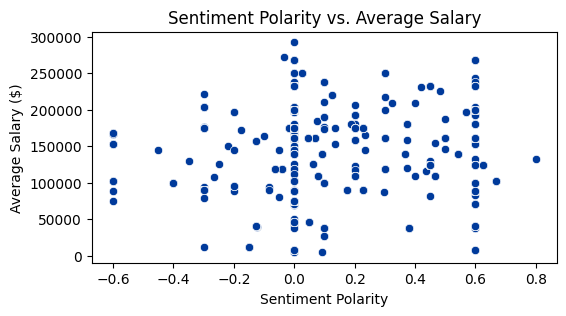

In [47]:
plt.figure(figsize=(6, 3))
sns.scatterplot(x='Sentiment_Polarity', y='Avg_Salary', data=salaries, color='#003a9b')
plt.title('Sentiment Polarity vs. Average Salary')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Average Salary ($)')
plt.show()

* A positive polarity: the job description is trying to attract candidates by highlighting benefits and opportunities.
* A negative polarity: the job description might be more realistic or even discouraging, possibly highlighting the challenges of the role.

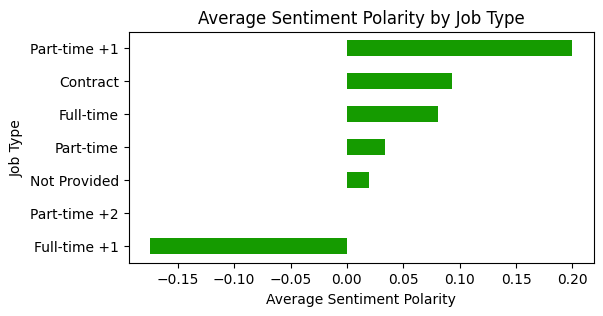

In [48]:
plt.figure(figsize=(6, 3))
avg_polarity_by_job_type.sort_values().plot(kind='barh', color='#159b00')
plt.title('Average Sentiment Polarity by Job Type')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('Job Type')
plt.show()

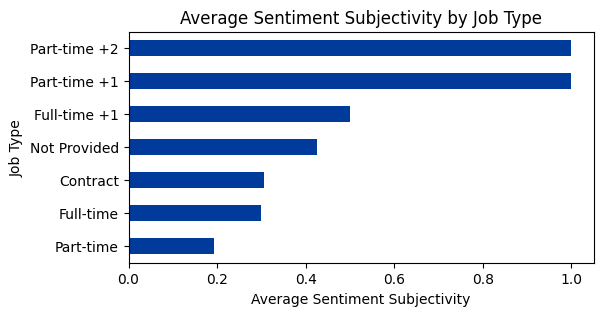

In [49]:
plt.figure(figsize=(6, 3))
avg_subjectivity_by_job_type.sort_values().plot(kind='barh', color='#003a9b')
plt.title('Average Sentiment Subjectivity by Job Type')
plt.xlabel('Average Sentiment Subjectivity')
plt.ylabel('Job Type')
plt.show()

* High subjectivity: job descriptions with high subjectivity might use persuasive language to attract candidates, emphasizing the company culture, values, or the personal benefits of the role.
* Low subjectivity: job descriptions with low subjectivity are likely to be straightforward and focused on the facts, e.g., job responsibilities, requirements, and qualifications.

## 3. Textual features importance: 
- which words or phrases in job descriptions are most predictive of higher salaries?

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
custom_stop_words = ['be', 'that', 'this', 'uniphore', 'and', 'or', 'is', 'are', 'it', 'we', 'you', 'the', 'wa', 'one']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=500, stop_words=custom_stop_words)  # Limit to the top 500 features for simplicity
X_tfidf = tfidf.fit_transform(salaries['Job-Description'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [51]:
X = pd.concat([X_tfidf_df], axis=1)
y = salaries['Avg_Salary']

from sklearn.linear_model import LassoCV

# Initialize Lasso Regression with cross-validation
lasso = LassoCV(cv=5, max_iter=1000, random_state=42)
lasso.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 951802509.6049728, tolerance: 809941463.3864578
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 977329267.1347656, tolerance: 809941463.3864578
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 911253126.1123505, tolerance: 808425306.9831944
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWar

LassoCV(cv=5, random_state=42)

In [52]:
# Get feature importance (coefficients)
feature_importance = pd.Series(lasso.coef_, index=X.columns)
important_features = feature_importance.sort_values(ascending=False)
print("Top features predictive of higher salaries:")
print(important_features.head(10))

Top features predictive of higher salaries:
product        218049.159268
assist         200373.071523
activation     194564.183997
open           186828.426236
integration    140182.005201
tesla          135318.105296
scientist      119249.586419
ai             116876.636408
lead            90246.786569
vision          81248.354689
dtype: float64


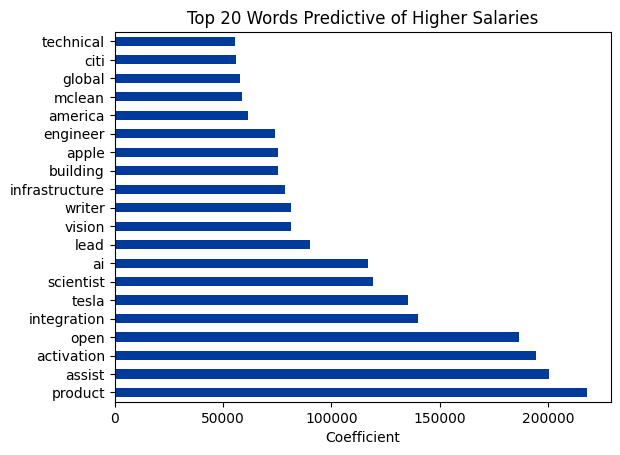

In [53]:
important_features.head(20).plot(kind='barh', title='Top 20 Words Predictive of Higher Salaries', color='#003a9b')
plt.xlabel('Coefficient')
plt.show()

## 4. Remote vs. on-site vs. hybrid salary comparison: 
- do remote jobs tend to have different salary ranges compared to on-site positions within the same job category?

I used the larger dataset since we only want to explore salaries and location

In [54]:
def classify_remote(location):
    if 'remote' in location.lower():
        return 'Remote'
    elif 'hybrid' in location.lower():
        return 'Hybrid'
    else:
        return 'On-site'

jobs['Work Type'] = jobs['Location'].apply(classify_remote)
jobs['Work Type'].value_counts()

Work Type
On-site    4798
Hybrid      679
Remote      438
Name: count, dtype: int64

In [55]:
jobs['General Category'] = jobs['Job Title'].apply(map_to_general_category) # use previous defined function to map the title to category
# group by Job Category and Remote Status, then calculate average salaries
category_salary = jobs.groupby(['General Category', 'Work Type'])['Avg_Salary'].mean().unstack()

<Figure size 600x1200 with 0 Axes>

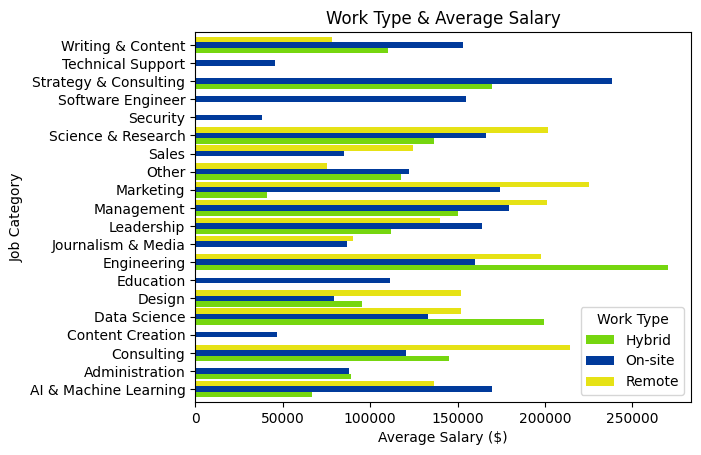

In [56]:
plt.figure(figsize=(6, 12))
category_salary.plot(kind='barh', stacked=False, color=['#76d60f', '#003a9b', '#e6e215'], width=0.9)
plt.title('Work Type & Average Salary')
plt.xlabel('Average Salary ($)')
plt.ylabel('Job Category')
plt.show()

#### check statistical difference

In [57]:
from scipy.stats import f_oneway, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# check for equal variances using Levene's test
remote_salaries = jobs[jobs['Work Type']=='Remote']['Avg_Salary']
onsite_salaries = jobs[jobs['Work Type'] == 'On-site']['Avg_Salary']
hybrid_salaries = jobs[jobs['Work Type'] == 'Hybrid']['Avg_Salary']
stat, p_value = levene(remote_salaries, onsite_salaries, hybrid_salaries)
print(f"Levene's Test for Equal Variances: p-value = {p_value}")

Levene's Test for Equal Variances: p-value = 0.0036479222951756054


In [58]:
# anova
anova_stat, anova_p = f_oneway(remote_salaries, onsite_salaries, hybrid_salaries)
print(f"Anova: F-statistic = {anova_stat}, p_value = {anova_p}")

Anova: F-statistic = 98.90213259944495, p_value = 5.626917408124514e-43


In [59]:
# if anova is significant, conduct post hoc test
if anova_p < 0.05: # common p-value
    salaries_data = jobs[['Avg_Salary', 'Work Type']].dropna()
    tukey = pairwise_tukeyhsd(endog=salaries_data['Avg_Salary'],
                             groups=salaries_data['Work Type'],
                             alpha=0.05)
    print(tukey)
else:
    print("No statistically significant difference found between the groups.")

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1  group2  meandiff  p-adj   lower      upper    reject
-------------------------------------------------------------
 Hybrid On-site 39666.3948   0.0 32126.5616 47206.2279   True
 Hybrid  Remote 61079.6224   0.0  49809.983 72349.2618   True
On-site  Remote 21413.2276   0.0 12234.3831 30592.0722   True
-------------------------------------------------------------


**Conclusion:**
* Hybrid jobs have significantly higher average salaries compared to both On-site and Remote jobs
* On-site jobs also have significantly higher average salaries than Remote jobs
* All pairwise comparisons (Hybrid vs. On-site, Hybrid vs. Remote, and On-site vs. Remote) show statistically significant differences in salaries

## Summary
### Data Preprocessing and Cleaning:
* Salary: salary data was initially unstructured (e.g., hourly, yearly, 10000 to 15,000, etc.). It was cleaned by extracting numeric values, converting hourly wages to yearly equivalents, and calculating the average salary where a range was provided
* Location: job locations were standardized into city and country formats
* Job title categorization: Job titles were cleaned, standardized, and grouped into broader categories (e.g., "AI & Machine Learning," "Software Engineer") to facilitate analysis of trends across job roles

### Key Findings:
**Salary Distribution:**
* The majority of jobs in the dataset offer average salaries ranging from 80k to 220k, with some outliers earning significantly more.
* Full-time positions generally offer higher salaries compared to part-time and contract jobs.
* *Hybrid jobs* were found to have significantly higher average salaries than both on-site and remote jobs, with remote jobs having the lowest average salaries. Tukey's HSD test confirmed that these differences were statistically significant.

**Sentiment Analysis of Job Descriptions:**
* Job descriptions' sentiment polarity varied significantly across job types. E.G., contract jobs often had neutral or slightly positive sentiment, while full-time positions had a broader range of sentiment.
* There was a weak positive correlation between sentiment polarity and average salary, suggesting that more positively framed job descriptions might be associated with higher salaries. However, subjectivity was negatively correlated, indicating that more fact-based descriptions might be linked to lower salaries.

**Textual Features Predictive of Salary:**
* A Lasso regression model identified key words and phrases most predictive of higher salaries. E.G., "product," "activation," and "integration" were strongly associated with higher salaries.
* Feature importance from a Gradient Boosting model highlighted that categories such as "Software Engineer" and "Leadership" were the most influential in predicting salary.
* The most common job titles in the dataset included roles like "AI Engineer," "AI Writer and Editor," and "Activation Lead."
* The word cloud and keyword analysis of job descriptions showed frequent use of terms related to AI, leadership, and technical skills, indicating a strong market demand for these competencies.

**Location:**
* The majority of job postings were based in the United States, with key cities being Palo Alto, Boston, and New York.